In [ ]:
import alfw
from alfw import Face
from alfw import Face, lmnames, goodmarksnames, split
import numpy as np

In [1]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import skimage
%matplotlib inline

In [2]:
from keras.initializations import *
from keras.models import Model
from keras.layers import Dropout, Activation, Flatten, Dense, Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Merge, Reshape
from keras.optimizers import Adam, SGD
from keras.objectives import mean_squared_error
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ProgbarLogger, EarlyStopping
from keras import backend as K
import keras
from sklearn import preprocessing
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from scipy.interpolate import lagrange, interp1d
from theano.sandbox.cuda.dnn import *
import sklearn.metrics
print(dnn_available())
print(dnn_available.msg)

Using Theano backend.
Using gpu device 2: Tesla K80 (CNMeM is disabled, cuDNN 5105)
/home/wp01/users/chevallierl/Annaconda2Ubuntu/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


True
None


/home/wp01/users/chevallierl/Annaconda2Ubuntu/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/home/wp01/users/chevallierl/Annaconda2Ubuntu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
Xtrain, ytrain, ht, mm, Xtest, ytest, hts, mmt, (mean, std, meany, stdy, meani, stdi), scale, unscale, d = alfw.prepare(200000, onlyvisible=True)
print 'ytrain ', ytrain.shape    
print Xtrain.shape

print 'mean ', np.mean(Xtrain, axis=3).shape

# to grey
Xtrain = np.mean(Xtrain, axis=3).reshape(Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2], 1)
Xtest = np.mean(Xtest, axis=3).reshape(Xtest.shape[0], Xtest.shape[1], Xtest.shape[2], 1)
Xtest1 = Xtest

# normalize between 0 , 1
Xtrain, ytrain, ht = scale( Xtrain, ytrain, ht )
Xtest, ytest, hts = scale( Xtest, ytest, hts )

loading..
im.shape:  (21776, 128, 128, 3)
feats.shape: (21776, 28, 2)
hogs.shape: (21776, 8100)
goodmarks  (12, 21776, 2)
assert  0
mask  (21776,)
8166 21776
mmm  (21776, 12, 2)
418769
rim.shape:  (8166, 128, 128, 3)
rfeats.shape: (8166, 12, 2)
rhogs.shape: (8166, 8100)
(7349, 8100)
(8100,)
ytrain.shape  (7349, 12, 2)
meany.shape  (12, 2)
stdy.shape  (12, 2)
(7349, 128, 128, 3)
()
mmm  (7349, 12, 2)
ytrain  (7349, 12, 2)
(7349, 128, 128, 3)
mean  (7349, 128, 128)


## Define a simple mlp with one hidden layer using KERAS

In [31]:
# simple mlp
# input is 2D grey scale
inputs = Input((1, alfw.size, alfw.size))
flat = Flatten()(inputs)

# flatten before feeding to fully connected
hidden = Dense(400, activation='relu')(flat)

## Relu activation

<img src ="http://danielnouri.org/media/kfkd/rectifier.png" width="25%">
\begin{align}
\max(x, 0)
\end{align}

In [32]:
for i in range(4):
    hidden = Dense(400, activation='relu')(hidden)

In [53]:
# output
h1 = Dense(ytrain.shape[1]*2)(hidden)
out = Reshape((ytrain.shape[1], 2))(h1)


r = Dense(1, activation='sigmoid')(hidden)

model = Model(input=inputs, output=out)

## Gradient Descent 

<img src ="http://i.imgur.com/s25RsOr.gif" width="25%">


In [54]:
# define the optimizer : stochastic gradient descent
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True, decay=1e-6)

## Binary cross entropy
\begin{align}
p . log(y) + (1-p) . log(1-y)
\end{align}

In [55]:
## binary cross entropy : measure how 2 boolean agree together
def bce(y, pred):
    return -pred * K.log(y) - (1 - y) * log(pred)

#model.compile(loss='binary_crossentropy', optimizer=sgd)

model.compile(loss='mean_squared_error', optimizer=sgd)
print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 1, 128, 128)   0                                            
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 16384)         0           input_3[0][0]                    
____________________________________________________________________________________________________
dense_15 (Dense)                 (None, 400)           6554000     flatten_3[0][0]                  
____________________________________________________________________________________________________
dense_16 (Dense)                 (None, 400)           160400      dense_15[0][0]                   
___________________________________________________________________________________________

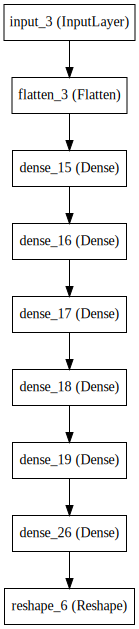

In [56]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [59]:
genders = np.asarray([x.genre == 'f' for x in d['md'][0]])
genders_test = np.asarray([x.genre == 'f' for x in d['md'][1]])
model.fit(np.transpose(Xtrain, (0, 3, 1, 2)),
                    ytrain, #genders,
                    batch_size=128,
                    nb_epoch=50, verbose=1, shuffle=True,
                    validation_split = 0.3)

Train on 5144 samples, validate on 2205 samples
Epoch 1/50
5144/5144 [==============================] - 0s - loss: 0.0069 - val_loss: 0.0085
Epoch 2/50
5144/5144 [==============================] - 0s - loss: 0.0063 - val_loss: 0.0081
Epoch 3/50
5144/5144 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0078
Epoch 4/50
5144/5144 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0077
Epoch 5/50
5144/5144 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0074
Epoch 6/50
5144/5144 [==============================] - 1s - loss: 0.0051 - val_loss: 0.0073
Epoch 7/50
5144/5144 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0071
Epoch 8/50
5144/5144 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0071
Epoch 9/50
5144/5144 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0070
Epoch 10/50
5144/5144 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0068
Epoch 11/50
5144/5144

In [25]:
sklearn.metrics.precision_score(genders_test , model.predict(np.transpose(Xtest, (0, 3, 1, 2)))[:,0]>0.5)

0.62730061349693256

In [44]:

#define the loss function
def loss(y, pred) :
    return K.mean(K.square(y[:,0] - pred[:,1]) + K.square(y[:,1] - pred[:,0]))

print model.summary()
r = Reshape((ytrain.shape[1], 2))(out)  # many outputs
model2 = Model(input=inputs, output=r)
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True, decay=1e-6)
model2.compile(loss='mean_squared_error', optimizer=sgd)
history = model2.fit(np.transpose(Xtrain, (0, 3, 1, 2)),
                    ytrain,
                    batch_size=128,
                    nb_epoch=100, verbose=0, shuffle=True,
                    validation_split = 0.3)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 1, 128, 128)   0                                            
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 16384)         0           input_3[0][0]                    
____________________________________________________________________________________________________
dense_15 (Dense)                 (None, 400)           6554000     flatten_3[0][0]                  
____________________________________________________________________________________________________
dense_16 (Dense)                 (None, 400)           160400      dense_15[0][0]                   
___________________________________________________________________________________________

In [45]:
model.save_weights('mlp.hdf5')

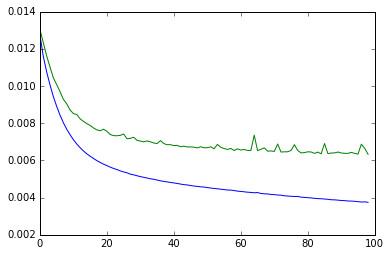

In [27]:
history.history
plt.plot(history.history['loss'][1:], color='blue', label='train')
plt.plot(history.history['val_loss'][1:], color='green' )

(817, 128, 128, 1)
(128, 128) (817, 12, 2)


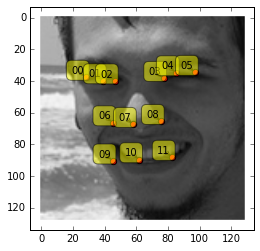

In [66]:
pred = unscale(model.predict(np.transpose(Xtest, (0, 3, 1, 2))))
print Xtest1.shape
exim = Xtest1.reshape(Xtest1.shape[0], Xtest1.shape[1], Xtest1.shape[2])[31,:,:]/255
print exim.shape, pred.shape
alfw.draw(np.dstack((exim, exim, exim)), pred[31, :, :])
#print pred[31,:,:]

rmse =  5.65192578831


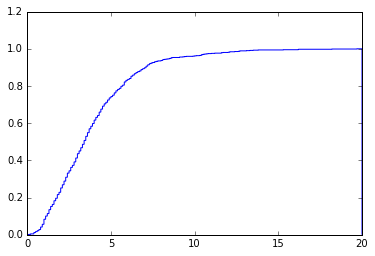

In [62]:

feat=0
predpos = pred[:, feat, :].T
gtpos = unscale(ytest)
gtpos = gtpos[:,feat,:].T
dist = np.linalg.norm(predpos - gtpos, 2, axis=0)
rmse = np.sqrt(np.mean(np.square(dist)))
n, bins, patches = plt.hist(dist, 200, normed=1,   histtype='step', cumulative=True, range=(0, 20))
print 'rmse = ', rmse

(360, 480, 3)


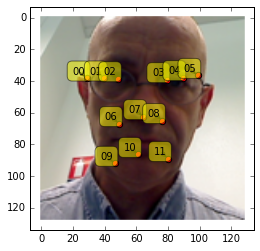

In [69]:
sys.path.append('./Demo_web')
import server
import facedetect

ff = facedetect.detect_and_crop(server.rin(), 0.1)
ffr = scipy.misc.imresize(ff, (128, 128), interp='bicubic')

ff = np.mean(ffr, axis=2)
#imshow(ff/255, cmap='gray')
#print ff[None, None, :,:].shape
fft = ff[None, None, :,:]


pred = unscale(model.predict(fft/255))[0,:,:]
#print pred
alfw.draw(ffr, pred)